# 2D Biometeorological Variable Analysis: Baseline vs. Scenario

This notebook provides a comprehensive analysis of 2D biometeorological variables (e.g., physiological equivalent temperature (PET)) from PALM (Potsdam Atmospheric Large-Eddy Simulation Model) 2D output files. It facilitates a comparative study between a Baseline simulation scenario and a modified Scenario 1, by performing the following key steps:
-   **Data Loading and Preprocessing:** Importing 2D `_av_xy_N03.000.nc` files and static driver data.
-   **Variable Selection:** Allowing interactive selection of the 2D biometeorological variable for analysis.
-   **Time Series Analysis:** Defining time sequences and equivalents for temporal aggregation and plotting.
-   **Statistical Comparison:** Performing independent t-tests between the two simulation scenarios across various Areas of Interest (AOIs) and increasing buffer distances.
-   **Visualization:** Generating line plots to illustrate the mean trends of the selected variable over time for different AOIs.
-   **Data Summarization:** Presenting key statistics (overall and daily min/max values) for both scenarios and summarizing t-test outcomes.

The primary objective is to assess the biometeorological impact of the changes introduced in Scenario 1 by comparing it against the Baseline, quantifying statistical differences, and visualizing temporal trends across the simulation domain and specific AOIs.

## 1. Import dependencies

This section imports all necessary libraries for numerical operations, NetCDF file handling, geographical data processing, statistical analysis, interactive widgets, and advanced plotting capabilities.

In [23]:
import os

import numpy as np
import netCDF4 as nc
from IPython.display import display
import ipywidgets as widgets
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FixedLocator
from matplotlib.ticker import MultipleLocator, FuncFormatter

import matplotlib.patches as mpatches
import matplotlib.patches as patches
import matplotlib.patheffects as pe
from mpl_toolkits.axes_grid1 import make_axes_locatable
import geopandas as gpd
import pandas as pd
from scipy import stats

import matplotlib.colors as mcolors
import geopandas as gpd
from matplotlib.colors import BoundaryNorm

from utils import palm_variables

## 2. Import data
This section defines the file paths for the 2D simulation output NetCDF files (for a baseline and a scenario run) and the static driver file. These files are then loaded into netCDF4 Dataset objects, making their contents accessible for processing. The buildings_2d data from the static driver is also extracted, which is used for masking non-atmospheric grid cells during data extraction

In [7]:
# Absolute URL of simulation output files and static driver
file_xy_1 = r"./Data/agg_6/konstanz_4096x4096_v9_Baseline_av_xy_N03_bio_pet_xy.nc"
file_xy_2 = r"./Data/agg_6/konstanz_4096x4096_v9_Scenario_1_av_xy_N03_bio_pet_xy.nc"
file_xy_ref = r"./Data/./_simulation_outputs_3/konstanz_4096x4096_v9_Baseline-48hr/OUTPUT/konstanz_4096x4096_v9_Baseline_av_xy_N03.000.nc"
file_static = r"./Data/INPUT/konstanz_4096x4096_v9_Baseline_static_N03"

# Read netCDF files
dataset_1 = nc.Dataset(file_xy_1, mode='r')
dataset_2 = nc.Dataset(file_xy_2, mode='r')
dataset_ref = nc.Dataset(file_xy_ref, mode='r')
dataset_3 = nc.Dataset(file_static, mode='r')

file_xy_list = [file_xy_1, file_xy_2]
dataset_list = [dataset_1, dataset_2]

# Extract 2D buildings data from the static dataset
buildings_2d = dataset_3['buildings_2d']
buildings_2d_data = buildings_2d[:, :]

## 3. Variable Selection
This section allows the user to interactively select a 2D variable from the loaded NetCDF datasets. A dropdown widget is provided for selection, and the chosen variable's description and unit (retrieved from the palm_variables module) are displayed for clear identification.

In [10]:
# Extract variable names from the first dataset where the number of dimensions is greater than 2.
# In PALM xy-averaged output files, these typically represent 2D spatial data over time (time, y, x).
var_names_palm = [var for var in dataset_1.variables if dataset_1.variables[var].ndim > 2]

# Initialize `test_variable` with the first variable in the list (`var_names_palm[0]`),
# which is commonly 'ta_2m*_xy' for 2-m air temperature.
test_variable = var_names_palm[0]

# Create a dropdown widget to allow the user to select the desired 2D variable.
drop_down = widgets.Dropdown(
    options=var_names_palm,         # Populate the dropdown with the extracted 2D variable names.
    value=var_names_palm[0],        # Set the initial selected value in the dropdown.
    description='Select test variable:' # Label displayed next to the dropdown.
)

# Define a handler function that will be called whenever the dropdown's value changes.
def dropdown_handler(change):
    global test_variable  # Declare `test_variable` as global to modify it.
    test_variable = change.new     # Update the global `test_variable` with the newly selected value.
    print(f"Selected variable: {test_variable}") # Print the newly selected variable to the console.

# Attach the `dropdown_handler` function to observe changes in the 'value' property of the dropdown.
drop_down.observe(dropdown_handler, names='value')

# Display the dropdown widget in the notebook output.
display(drop_down)

Dropdown(description='Select test variable:', options=('bio_pet*_xy',), value='bio_pet*_xy')

In [11]:
# Check if the selected `test_variable` string contains a wildcard character '*'.
# This is common for PALM variables indicating an xy-averaged or general 2D field.
if "*" in test_variable:
    # If a wildcard is present, extract the base part of the variable name (e.g., 'ta_2m' from 'ta_2m*_xy')
    # and re-append '*' to match the keys in `palm_variables.variables_dict`.
    var_initial = test_variable.split("*")[0] + "*"
    # Retrieve the dictionary of information for `var_initial` from the `palm_variables` module.
    variable_info = palm_variables.variables_dict.get(var_initial, {})
    # Extract the 'unit' from `variable_info`, defaulting to 'No unit available' if the key is missing.
    unit = variable_info.get('unit', 'No unit available')
    # Extract the 'description' from `variable_info`, defaulting to 'No description available' if the key is missing.
    description = variable_info.get('description', 'No description available')
    # Print the capitalized description and its unit.
    print(f"{description.capitalize()}, {unit}")

Physiologically equivalent temperature (pet), °C


## 4. Define Time Sequences and Equivalents
This section dynamically extracts the total number of time steps from the loaded dataset. It then defines parameters for time step intervals and calculates sequences and human-readable time equivalents (HH:MM format) for both hourly and all time steps. These sequences are crucial for temporal aggregation and plotting.

In [13]:
# Extract `variable_data_1` for the `test_variable` from the first dataset.
variable_data_1 = dataset_1[test_variable]

# Get the shape of `variable_data_1` to determine the total number of time steps.
variable_data_shape = np.shape(variable_data_1)
total_time_steps = variable_data_shape[0] # The first dimension is usually time.

# Display the total number of time steps.
total_time_steps

288

In [14]:
# Define `time_step_interval`: This controls how frequently data points are sampled or aggregated.
# In PALM, each time step typically represents 10 minutes.
#   - `time_step_interval = 1`: Corresponds to every 10-minute interval.
#   - `time_step_interval = 6`: Corresponds to hourly intervals (6 * 10 minutes = 60 minutes).
time_step_interval = 6

# Define `second_step`: This offset helps align `time_sequence_hourly` with actual hour marks.
# If time steps are 0-indexed and represent 10-minute intervals:
#   - `second_step = 0`: Corresponds to 0:00, 0:10, 0:20...
#   - `second_step = 5`: Corresponds to 0:50, 1:50, 2:50... (often used for hourly averages centered at the hour)
second_step = 5

# `time_sequence_hourly`: A list of time step indices for hourly intervals.
# It starts at `0` and extends by `time_step_interval` from `second_step`.
time_sequence_hourly = [0]
time_sequence_hourly.extend(np.arange(second_step, total_time_steps, time_step_interval))

# `time_sequence_all`: A list containing all available time step indices (from 0 to `total_time_steps - 1`).
time_sequence_all = range(total_time_steps)

def get_time_equivalent(time_sequence):
    """
    Converts a sequence of time steps (each representing 10 minutes) into
    human-readable HH:MM format.

    Args:
        time_sequence (list or array): A list of time step indices.

    Returns:
        tuple: A tuple containing:
            - time_equivalent (list): List of time strings in HH:MM format (can exceed 24 hours).
            - time_equivalent_24hr (list): List of time strings in 24-hour HH:MM format (resets after 23:50).
    """
    time_equivalent = []
    time_equivalent_24hr = []
    
    for time_step in time_sequence:
        # Calculate total minutes from the start of the simulation (each step is 10 minutes).
        total_minutes = (time_step + 1) * 10 
        hours, minutes = divmod(total_minutes, 60) # Convert total minutes to hours and remaining minutes.
        
        # Append time equivalent in HH:MM format (hours can exceed 24, e.g., 25:00 for the next day).
        time_equivalent.append(f"{hours:02d}:{minutes:02d}")
        
        # Calculate hours in a 24-hour cycle for `time_equivalent_24hr`.
        hours_24hr = hours % 24 
        time_equivalent_24hr.append(f"{hours_24hr:02d}:{minutes:02d}")
    
    return time_equivalent, time_equivalent_24hr

# Generate time equivalents for hourly and all time steps.
time_equivalent_hourly, time_equivalent_hourly_24hr = get_time_equivalent(time_sequence_hourly)
time_equivalent_all, time_equivalent_all_24hr = get_time_equivalent(time_sequence_all)

## 5. Helper Functions for Spatial Operations and Plotting
This section defines several helper functions crucial for spatial data manipulation and plot customization. These include functions for calculating grid coordinates, adjusting plot ticks, determining the date based on time index, and adding north arrows and scale bars to plots.

In [21]:
# Define grid spacing
dx = dataset_ref['x'][1]-dataset_ref['x'][0]
dy = dataset_ref['y'][1]-dataset_ref['y'][0]
# Define number of cells
nx = np.shape(dataset_ref['x'])[0]
ny = np.shape(dataset_ref['y'])[0]

# Coordinates of origin in PALM
origin_x, origin_y, origin_z = dataset_ref.origin_x, dataset_ref.origin_y, dataset_ref.origin_z

# Vector for coordinate at cell edges
x = np.arange(nx+1)*dx + origin_x
y = np.arange(nx+1)*dy + origin_y
# Vector for coordinates at cell centers
xc = np.arange(nx)*dx + origin_x + dx/2
yc = np.arange(nx)*dy + origin_y + dy/2

# Time
origin_time = dataset_ref.origin_time
time_step = 600  # ds.time_step
nt = np.shape(dataset_ref['time'])[0]

In [24]:
# Define a custom color sequence
if test_variable == 'bio_pet*_xy':
    custom_colors = ['#36b3d3', '#9bcdfe', '#afed00', '#ffff01', '#ffcb01', '#fe9900', '#fe0002']
    custom_colors_dark = ['#1693b3', '#7badde', '#0fdd00', '#d1d101', '#df7b00', '#de7100', '#a10000']
    bin_edges = [0, 13, 18, 23, 29, 35, 41, 50.0]
    tick_labels = ['<13', '13', '18', '23', '29', '35', '41', '>41']
    labels = ['Varying cold', 'Slightly cool', 'Comfortable', 'Slightly warm', 'Warm', 'Hot', 'Very Hot']
    cmap = mcolors.LinearSegmentedColormap.from_list('cmap_pet', custom_colors)
    norm = BoundaryNorm(bin_edges, ncolors=cmap.N, clip=True)
    cmap.set_bad('#474747') #474747

elif test_variable == 'bio_utci*_xy':
    custom_colors = ['#66ffff', '#93d150', '#ffc100', '#ff9932', '#ff3200', '#bf0000']
    bin_edges = [0, 9, 26, 32, 38, 46, 55]
    tick_labels = ['<9', '9', '26', '32', '38', '46', '>46']
    labels = ['Varying cold stress', 'No thermal stress', 'Moderate heat stress',
              'Strong heat stress', 'Very strong heat stress', 'Extremet heat stress']
    cmap = mcolors.LinearSegmentedColormap.from_list('cmap_utci', custom_colors)
    norm = BoundaryNorm(bin_edges, ncolors=cmap.N, clip=True)
    cmap.set_bad('#474747') #474747

In [25]:
def center_yticks():
    # Get the current y-tick positions and labels
    tick_positions = ax.get_yticks()
    tick_labels = [f'{pos:.2f}' for pos in tick_positions]
    # Set the tick positions explicitly using FixedLocator
    ax.yaxis.set_major_locator(FixedLocator(tick_positions))
    # Set the y-tick labels with the correct alignment
    ax.set_yticklabels(tick_labels, rotation=90, verticalalignment='center', fontsize=12)

def center_ax_yticks(ax):
    """
    Centers the y-tick labels of a given matplotlib Axes object.

    Args:
        ax (matplotlib.axes.Axes): The Axes object to modify.
    """
    # Get the current y-tick positions and labels
    tick_positions = ax.get_yticks()
    tick_labels = [f'{pos:.2f}' for pos in tick_positions]
    # Set the tick positions explicitly using FixedLocator
    ax.yaxis.set_major_locator(FixedLocator(tick_positions))
    # Set the y-tick labels with the correct alignment
    ax.set_yticklabels(tick_labels, rotation=90, verticalalignment='center', fontsize=12)


def get_date_day(time_index):
    """
    Determines the date day based on the time index.

    Args:
        time_index (int): The current time index.

    Returns:
        int: The day of the month (14 or 15) corresponding to the time index.
    """
    if time_index<=144:
        return 14
    elif time_index>144:
        return 15

In [26]:
def get_extents(gdf_combined, location_id, increased_distance):
    """
    Calculates the spatial extents (min/max x/y indices) for a given location
    from a combined GeoDataFrame, with an optional increased distance (buffer).

    Args:
        gdf_combined (geopandas.GeoDataFrame): Combined GeoDataFrame containing location geometries.
        location_id (int): Index of the location in gdf_combined.
        increased_distance (int): Buffer distance to apply to the bounding box.

    Returns:
        tuple: A tuple (x_low, y_low, x_high, y_high) representing the array indices of the extent.
    """
    polygon_aug = gdf_combined.iloc[location_id]
    polygon = polygon_aug.geometry
    min_x, min_y, max_x, max_y = polygon.bounds
    # Convert geographic coordinates to array indices
    x1, y1, x2, y2 = int((min_x-origin_x)/dx), int((min_y-origin_y) /
                                                   dx), int((max_x-origin_x)/dx), int((max_y-origin_y)/dx)

    # change extents value based on buffer distance
    half_window = int(increased_distance/2)

    x_low, x_high = x1-half_window, x2+half_window
    y_low, y_high = y1-half_window, y2+half_window;

    # Ensure indices are within valid bounds (0 to 256 for a 256x256 grid)
    if x_low <= 0:
        x_low = 0
    if y_low <= 0:
        y_low = 0
    if x_high >= 256: # Assuming 256 as max extent for now
        x_high = 256
    if y_high >= 256: # Assuming 256 as max extent for now
        y_high = 256

    return (x_low, y_low, x_high, y_high)

In [27]:
def plot_north_arrow_and_scale_bar():
    """
    Adds a north arrow and a scale bar to the current matplotlib Axes.
    Assumes `ax` is the current Axes object to which these elements should be added.
    """
    # Add north arrow (location: top right corner)
    top_right_x = 513390
    top_right_y = 5278890
    arrow = patches.FancyArrowPatch((top_right_x, top_right_y - 40), (top_right_x, top_right_y),
                                    arrowstyle='simple',  linewidth=1.5, mutation_scale=25, color='k')
    ax.text(top_right_x, top_right_y - 50, 'N', fontsize=20, color='k', ha='center', va='center', weight='bold')
    ax.add_patch(arrow)    

    # Add scale bar (location: bottom right corner)
    scale_bar_x = 513250
    scale_bar_y = 5278410
    scale_bar_length_meters = 150  # Length of the scale bar in meters
    scale_bar_segment_length = 50  # Length of each alternating segment in meters
    
    # Create the scale bar as a collection of alternating segments
    num_segments = int(scale_bar_length_meters / scale_bar_segment_length)
    num_labels = num_segments+1
    segment_width = scale_bar_length_meters / num_segments
    for i in range(num_segments):
        if i % 2 == 0:
            segment_color = 'k'  # Black for even segments
        else:
            segment_color = 'w'  # White for odd segments
        segment_x = scale_bar_x + i * segment_width
        scale_bar_segment = patches.Rectangle((segment_x, scale_bar_y), segment_width, 15, linewidth=1, edgecolor='w', facecolor=segment_color)
        ax.add_patch(scale_bar_segment)
    
    for i in range(num_labels):
        # Add a label to the scale bar with a white border
        scale_bar_label = f'{i*scale_bar_segment_length}m'
        text_x = scale_bar_x + scale_bar_segment_length * i
        text_y = scale_bar_y + 25
        ax.text(text_x, text_y, scale_bar_label, fontsize=10, ha='center', color='k', weight='bold',
            path_effects=[pe.withStroke(linewidth=1, foreground='white')],
            bbox=dict(facecolor='white', edgecolor='white', boxstyle='round, pad=0.1'))

## 6. Extract Variable Data and Define Areas of Interest (AOIs)
This section loads the selected variable data from both simulation scenarios and reads shapefiles defining specific Areas of Interest (AOIs). These AOIs will be used to extract relevant data subsets for statistical analysis and comparison. Predefined lists for scenario names and AOI labels are also set up.

In [30]:
# Load `variable_data_1` and `variable_data_2` for the `test_variable` from the respective datasets.
variable_data_1 = dataset_1[test_variable]
variable_data_2 = dataset_2[test_variable]
variable_datas = [variable_data_1, variable_data_2]

# Define names for the simulation scenarios, to be used in labels and legends.
sim_scenarions = ['Baseline (BS)', 'Scenario 1 (S1)']
sim_scene = ['BS', 'S1']

# Define paths to shapefiles containing AOI definitions.
# `shapefile_path_child_ii`: For "Child II" AOIs.
shapefile_path_child_ii = r"./Data/shapefiles/03_AOI_Child_II.shp"
# `shapefile_path_uhi_study`: For Urban Heat Island (UHI) study AOIs.
shapefile_path_uhi_study = r"./Data/shapefiles/UHI_aoi_study_fitted.shp"

# Read the shapefiles into GeoDataFrames.
gdf_child = gpd.read_file(shapefile_path_child_ii)
gdf_uhi = gpd.read_file(shapefile_path_uhi_study)

# Combine the GeoDataFrames into a single GeoDataFrame for unified indexing of all AOIs.
gdf_combined = gpd.pd.concat([gdf_child, gdf_uhi], ignore_index=True)

# Define lists of location names and AOI names, corresponding to the combined GeoDataFrame.
# These will be used for labeling plots and tables.
location_name_list = ['Overall', 'Stephansplatz', 'Markstaette', 'Augustinerplatz']
aoi_name_list = ['Overall', 'AOI1', 'AOI2', 'AOI3']

## 7. Define Aggregation Logic
This section defines the get_aggregate_time_list function, which creates lists of time steps for temporal aggregation. This function is designed to generate moving windows of time steps, enabling the calculation of aggregated values (e.g., averages) over specified durations, which can then be used in statistical analyses.

In [31]:
def get_aggregate_time_list(total_time_steps, aggregate_time_steps):
    """
    Generates a list of time step lists for aggregation, creating a sliding window
    around each time step based on the `aggregate_time_steps`.

    Args:
        total_time_steps (int): The total number of time steps available.
        aggregate_time_steps (int): The number of time steps to aggregate (window size).

    Returns:
        list: A list of lists, where each inner list contains time steps for a specific aggregation.
    """
    time_lists = []
    
    for i in range(total_time_steps):
        if aggregate_time_steps <= 1:
            time_list = [i]
        else:
            half_window = aggregate_time_steps // 2
            if aggregate_time_steps % 2 == 0:
                time_list = [j for j in range(i - (half_window), i + half_window + 1)]
            else:
                time_list = [j for j in range(i - half_window, i + half_window + 1)]
        
        # Ensure indices are within bounds
        valid_time_list = [j for j in time_list if 0 <= j < total_time_steps]
        time_lists.append(valid_time_list)
    
    return time_lists

In [38]:
# Initialize global variables to store the overall maximum and minimum values.
# `value_maximum` is set to 0, `value_minimum` is set to a very large number to ensure any real value updates it.
global value_maximum, value_minimum
value_maximum = -99999
value_minimum = 999999

# Iterate through all available time steps.
for time_index_test in time_sequence_all:
    value_test_1 = variable_data_1[time_index_test, 0, :, :]
    value_test_2 = variable_data_2[time_index_test, 0, :, :]
    
    max_value_test = max(np.nanmax(value_test_1), np.nanmax(value_test_2))
    min_value_test = min(np.nanmin(value_test_1), np.nanmin(value_test_2))

    if value_maximum <= max_value_test:
        value_maximum = max_value_test
    if value_minimum >= min_value_test:
        value_minimum = min_value_test

# Print the final global maximum and minimum values found.
print(f"Overall Maximum: {value_maximum:.2f}")
print(f"Overall Minimum: {value_minimum:.2f}")

Overall Maximum: 59.27
Overall Minimum: 13.40


## Create DataFrame for Statistics

This section defines a function to create a Pandas DataFrame containing aggregated statistical data (mean, t-statistic, p-value) for the selected variable across different time steps and simulation scenarios within a specified Area of Interest (AOI). A two-sample t-test is performed to compare the means of the two scenarios.

In [39]:
def create_aggregated_dataframe(loc_id, inc_dist, time_lists):
    """
    Creates a DataFrame with aggregated statistics (mean, t-statistic, p-value)
    for a given location and increased distance, across specified time lists.

    Args:
        loc_id (int): The ID of the location to analyze.
        inc_dist (int): The increased distance (buffer) for the location's extent.
        time_lists (list): A list of lists, where each inner list contains time steps for aggregation.

    Returns:
        pandas.DataFrame: A DataFrame containing the aggregated statistics for the two scenarios.
    """
    # Define extents for location id
    x_low, y_low, x_high, y_high = get_extents(gdf_combined, loc_id, inc_dist)
    print(x_low, y_low, x_high, y_high)
    
    # Define increased distances
    alpha = 0.05
    # store results
    mean1, mean2 = [], []
    t_statistics, p_values_ttest = [], []
    t_test_results = []
    
    for time_list in time_lists:
        # Create list
        values_real_1 = []
        values_real_2 = []
        
        for time_index in time_list:
            # Extract values for each time_index and remove masked values
            values_time_index_1 = variable_data_1[time_index, 0, y_low:y_high, x_low:x_high]
            values_time_index_2 = variable_data_2[time_index, 0, y_low:y_high, x_low:x_high]
            # values_time_index_1.mask = ~buildings_2d_data.mask
            # values_time_index_2.mask = ~buildings_2d_data.mask
            
            values_time_index_real_1 = values_time_index_1.compressed()
            values_time_index_real_2 = values_time_index_2.compressed()
            
            # Extend real values to list
            values_real_1.extend(values_time_index_real_1)
            values_real_2.extend(values_time_index_real_2)

        mean1.append(np.nanmean(values_real_1))
        mean2.append(np.nanmean(values_real_2))
        
        t_statistic, p_value_ttest = stats.ttest_ind(values_real_1, values_real_2)
        
        # Append t-statistic and p-value to lists
        t_statistics.append(t_statistic)
        p_values_ttest.append(p_value_ttest)
        
        # Determine t-test result based on alpha
        if p_value_ttest < alpha:
            t_test_results.append("Reject null")
        else:
            t_test_results.append("Failed to reject null")

    # Combine all results into a DataFrame
    df_data = {
        'Time step': time_sequence_all,
        'Time (hr)': time_equivalent_all,
        'Mean (BS)': [f"{i:.2f}" for i in mean1],
        'Mean (S1)': [f"{i:.2f}" for i in mean2],
        'alpha': f"{alpha:.2f}",
        't_stat': [f"{t:.3e}" for t in t_statistics],
        'p-value': [f"{p:.3e}" for p in p_values_ttest],
        't-test': t_test_results,
    }
    # Create DataFrame
    df = pd.DataFrame(df_data)
    return df

In [40]:
inc_dist = 10
aggregate_time_steps = 6
time_lists = get_aggregate_time_list(total_time_steps, aggregate_time_steps)

df_0 = create_aggregated_dataframe(0, inc_dist, time_lists)
df_1 = create_aggregated_dataframe(1, inc_dist, time_lists)
df_2 = create_aggregated_dataframe(2, inc_dist, time_lists)
df_3 = create_aggregated_dataframe(3, inc_dist, time_lists)

df_list = [df_0, df_1, df_2, df_3]

0 0 256 256
38 141 90 193
157 71 198 90
45 9 81 47


In [41]:
def plot_bio_linegraph(df, df_index):
    """
    Plots a line graph of biometeorological variable means for different scenarios
    over time, including thermal comfort zones and customized aesthetics.

    Args:
        df (pandas.DataFrame): DataFrame containing 'Time step', 'Mean (BS)', and 'Mean (S1)'.
        df_index (int): Index to retrieve the location name from `location_name_list`.
    """
    # Plot line graph
    fig, ax = plt.subplots(figsize=(18, 8), facecolor='w', edgecolor='k')

    # Title and labels
    plt.suptitle(f"{description}, {unit}", fontsize=18, weight='bold')
    
    ax.set_title(f"Standort: {location_name_list[df_index]}",
                 fontsize=14)
    plt.subplots_adjust(top=0.90)

    # Define grid and axis
    ax.grid(which='major', axis='both', linestyle='-', linewidth=1, color='#00000050', alpha=0.15)
    ax.minorticks_on()
    ax.tick_params(axis='x', labelsize=12, rotation=0, width=1.5)
    ax.tick_params(axis='y', labelsize=12, rotation=90, width=1.5)

    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: f'{y:.2f}'))
    ax.set_xlabel(f"Zeit (h)", fontsize=14, weight='bold')
    ax.xaxis.set_label_coords(0.5, -0.1)
    ax.set_ylabel(f"PET ({unit})", fontsize = 14, weight='bold')

    ax.margins(0) # remove default margins (matplotlib verision 2+)
    
    # Set x-axis ticks and secondary x-axis for dates
    ax.xaxis.set_ticks(time_sequence_hourly, time_equivalent_hourly_24hr)
    for i, label in enumerate(ax.get_xticklabels()):
        if i % 2 != 0:
            label.set_visible(False)               
    
    # Set secondary xtick
    sec = ax.secondary_xaxis(location=0.015)
    sec.set_xticks([72, 72+144], labels=['\n\n(2023-06-14 +01)', '\n\n(2023-06-15 +01)'])
    sec.tick_params('x', length=0, labelsize=12)
    sec.spines['bottom'].set_linewidth(0)

    # Add thermal comfort zones as shaded regions
    if test_variable == 'bio_pet*_xy':
        # ax.axhspan(0,13, facecolor='#36b3d3', alpha=0.5)
        ax.axhspan(13,18, facecolor='#9bcdfe', alpha=0.5)
        ax.axhspan(18,23, facecolor='#afed00', alpha=0.5)
        ax.axhspan(23,29, facecolor='#ffff01', alpha=0.5)
        ax.axhspan(29,35, facecolor='#ffcb01', alpha=0.5)
        ax.axhspan(35,41, facecolor='#fe9900', alpha=0.5)
        ax.axhspan(41,50, facecolor='#fe0002', alpha=0.5)
    elif test_variable == 'bio_utci*_xy':
        # ax.axhspan(0,9, facecolor='#66ffff', alpha=0.5)
        ax.axhspan(15,26, facecolor='#93d150', alpha=0.5)
        ax.axhspan(26,32, facecolor='#ffc100', alpha=0.5)
        ax.axhspan(32,38, facecolor='#ff9932', alpha=0.5)
        ax.axhspan(38,40, facecolor='#ff3200', alpha=0.5)
        # ax.axhspan(46,55, facecolor='#bf0000', alpha=0.5)

    # Plot data
    line1, = ax.plot(df['Time step'], df['Mean (BS)'].astype(float),
                    label='Mittelwert (BS)',
                    color = '#ff0000', linestyle='--')
    line2, = ax.plot(df['Time step'], df['Mean (S1)'].astype(float),
                    label='Mittelwert (S1)',
                    color = '#006600', linestyle='--')
    
    # Center y-tick labels
    center_ax_yticks(ax)

    # Add legend
    # Create color patches and labels for legend
    legend_patches = [
        mpatches.Patch(color='#9bcdfe', label='Kältebelastung​'),
        mpatches.Patch(color='#afed00', label='Keine Wärmebelastung​'),
        mpatches.Patch(color='#ffff01', label='Moderate Wärmebelastung​'),
        mpatches.Patch(color='#ffcb01', label='Starke Wärmebelastung​'),
        mpatches.Patch(color='#fe9900', label='Sehr starke Wärmebelastung​'),
        mpatches.Patch(color='#fe0002', label='Extreme Wärmebelastung​')
    ]
    legend_patches.reverse()

    # Add legend
    handles_lines = []
    handles_lines.append(line1)
    handles_lines.append(line2)

    ax.legend(handles=handles_lines + legend_patches, 
            title=f"{(description.split(' ')[-1])}, {unit}",
            title_fontsize=16,
            fontsize=12,
            loc='center left',  # Adjust location to the right side
            bbox_to_anchor=(1,0.5))  # Adjust anchor point

    plt.show()

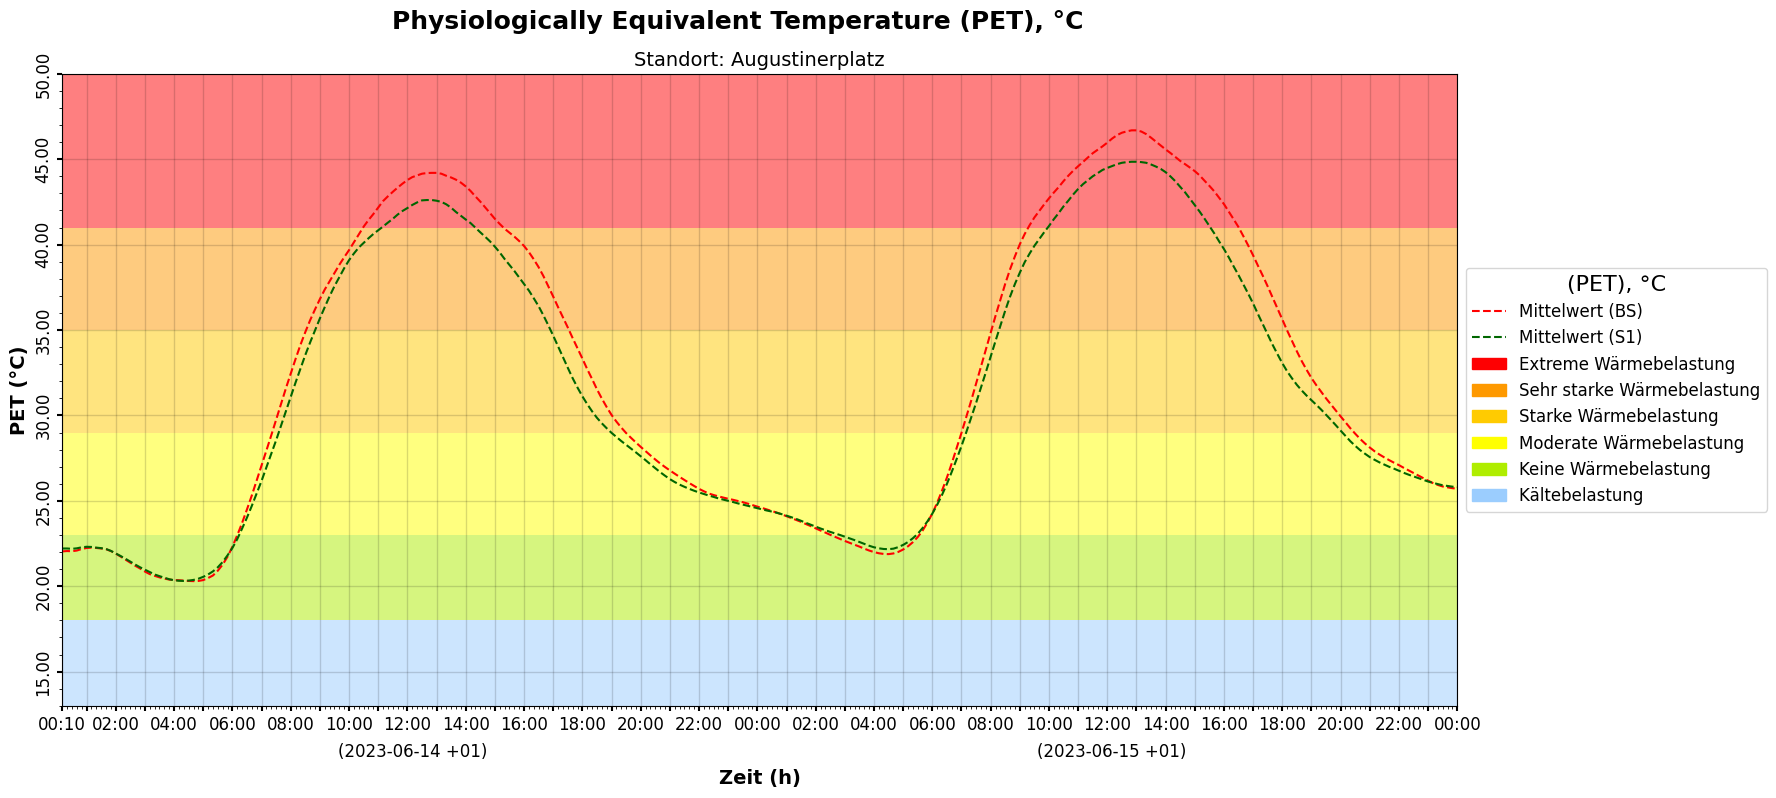

In [42]:
df_list = [df_0, df_1, df_2, df_3] 
df_test_index = 3

df_test = df_list[df_test_index]
plot_bio_linegraph(df_test, df_test_index)